# Predicting loan default with ML

#### Data from a Kaggle competition: https://www.kaggle.com/competitions/predict-loan-default/data

In [1]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns

# Train test split
from sklearn.model_selection import train_test_split

# Pipline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Model train
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier

# Model accuracy
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

### First review to the data

In [2]:
train = pd.read_csv('train.csv')
train.head()

,Id,Income,Age,Experience,Married.Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,153826,2453544,47,10,single,rented,no,Architect,Bharatpur,Rajasthan,5,14,0
1,54421,2192899,45,12,single,rented,no,Drafter,Giridih,Jharkhand,6,10,0
2,6621,6474294,48,9,single,rented,no,Comedian,Amritsar,Punjab,8,13,0
3,103101,220528,72,18,married,rented,no,Technology_specialist,Hapur,Uttar_Pradesh,4,12,0
4,216287,5786391,73,6,married,rented,no,Microbiologist,Kakinada,Andhra_Pradesh,6,14,0


- The data set contains 13 variables including Id and Risk_Flag being this one the target variable, which indicates if a customer is risky or not

In [3]:
train.shape

(176400, 13)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176400 entries, 0 to 176399
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 176400 non-null  int64 
 1   Income             176400 non-null  int64 
 2   Age                176400 non-null  int64 
 3   Experience         176400 non-null  int64 
 4   Married.Single     176400 non-null  object
 5   House_Ownership    176400 non-null  object
 6   Car_Ownership      176400 non-null  object
 7   Profession         176400 non-null  object
 8   CITY               176400 non-null  object
 9   STATE              176400 non-null  object
 10  CURRENT_JOB_YRS    176400 non-null  int64 
 11  CURRENT_HOUSE_YRS  176400 non-null  int64 
 12  Risk_Flag          176400 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 17.5+ MB


### Split in train_set and validation set + Understaning data

In [5]:
train_set, validation_set = train_test_split(train, test_size=0.2, random_state=42)

In [6]:
print(train_set.shape)
print(validation_set.shape)

(141120, 13)
(35280, 13)


### Is the data set unbalanced?

In [7]:
print(train_set.groupby('Risk_Flag').size() / len(train_set))

Risk_Flag
0    0.877353
1    0.122647
dtype: float64


#### 12% is only marked as 1 in the target variable, so let's create a new train_set with a balanced random sample

In [8]:
df_riesgo = train_set[train_set['Risk_Flag'] == 1]
df_no_riesgo = train_set[train_set['Risk_Flag'] == 0]
tamano = len(df_riesgo)

# Random sample
df_no_riesgo_sampleado = df_no_riesgo.sample(n=tamano, random_state=42)

# New balanced train_set
train_set = pd.concat([df_riesgo, df_no_riesgo_sampleado], axis=0).reset_index(drop=True)

In [9]:
print(train.groupby('Risk_Flag').size())
print(train_set.groupby('Risk_Flag').size())
print(validation_set.groupby('Risk_Flag').size())

Risk_Flag
0    154744
1     21656
dtype: int64
Risk_Flag
0    17308
1    17308
dtype: int64
Risk_Flag
0    30932
1     4348
dtype: int64


### Some statistics of the variables

In [10]:
train_set.describe(include=object)

,Married.Single,House_Ownership,Car_Ownership,Profession,CITY,STATE
count,34616,34616,34616,34616,34616,34616
unique,2,3,2,51,317,29
top,single,rented,no,Physician,Indore,Uttar_Pradesh
freq,31360,32111,24662,823,216,3907


In [11]:
train_set.groupby('House_Ownership').size()

House_Ownership
norent_noown      916
owned            1589
rented          32111
dtype: int64

In [12]:
train_set.describe()

,Id,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,34616.000000,3.461600e+04,34616.000000,34616.000000,34616.000000,34616.000000,34616.000000
mean,128312.975994,4.990571e+06,49.463485,9.846198,6.266611,11.992865,0.500000
std,76292.958045,2.899464e+06,17.216963,6.024720,3.691413,1.399358,0.500007
min,8.000000,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,61289.000000,2.450491e+06,34.000000,5.000000,3.000000,11.000000,0.000000
50%,128629.500000,5.003298e+06,49.000000,10.000000,6.000000,12.000000,0.500000
75%,198635.000000,7.505622e+06,64.000000,15.000000,9.000000,13.000000,1.000000
max,251993.000000,9.999180e+06,79.000000,20.000000,14.000000,14.000000,1.000000


### Pipline for data set prepropossesing

In [13]:
# Ordinal variables to be scaled
cols_ordinal_scaled = ['Profession', 'CITY', 'STATE']

# Categorical to apply one hot
cols_onehot = ['Married.Single', 'House_Ownership', 'Car_Ownership']

# Numeric variables to be scaled
cols_numeric_scaled = ['Income', 'Age']

# Variables that do not requiered any transformation
cols_passthrough = ['Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']

# Descriptive fugures that will be used in the model
features_deseadas = [
    'Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS',
    'Profession', 'CITY', 'STATE',
    'Married.Single_single', 'House_Ownership_owned', 
    'House_Ownership_rented', 'Car_Ownership_yes'
]

def construir_pipeline_filtrado():
    ordinal_pipeline = Pipeline([
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))#,
        #('scaler', StandardScaler())
    ])
    
    numeric_pipeline = Pipeline([
        ('scaler', StandardScaler())
    ])

    preprocesador = ColumnTransformer(transformers=[
        ('ord_scaled', ordinal_pipeline, cols_ordinal_scaled),
        ('onehot', OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore'), cols_onehot),
        ('num_scaled', numeric_pipeline, cols_numeric_scaled),
        ('passthrough', 'passthrough', cols_passthrough)
    ], remainder='drop', verbose_feature_names_out=False)

    return Pipeline([
        ('preprocesador', preprocesador)
    ])

def aplicar_pipeline_con_filtro(df, pipeline, target_col='Risk_Flag'):
    y = df[target_col] if target_col in df.columns else None
    X_raw = df.drop(columns=[target_col], errors='ignore')

    X_array = pipeline.fit_transform(X_raw)

    nombres_totales = pipeline.named_steps['preprocesador'].get_feature_names_out()

    X_df = pd.DataFrame(X_array, columns=nombres_totales, index=df.index)

    columnas_finales = [col for col in features_deseadas if col in X_df.columns]
    X_final = X_df[columnas_finales]

    return X_final, y

In [14]:
pipeline = construir_pipeline_filtrado()

# Training
X_train, y_train = aplicar_pipeline_con_filtro(train_set, pipeline)

In [15]:
X_train.head()

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Profession,CITY,STATE,Married.Single_single,House_Ownership_owned,House_Ownership_rented,Car_Ownership_yes
0,0.894298,-1.246666,4.0,4.0,11.0,41.0,251.0,13.0,1.0,0.0,1.0,0.0
1,1.303356,-1.537081,13.0,9.0,10.0,13.0,101.0,25.0,1.0,0.0,1.0,0.0
2,0.604797,0.379661,13.0,8.0,14.0,38.0,307.0,25.0,1.0,0.0,1.0,1.0
3,-0.660500,-1.014333,17.0,3.0,13.0,32.0,46.0,6.0,1.0,0.0,1.0,0.0
4,-0.256365,0.728160,15.0,4.0,10.0,42.0,86.0,1.0,0.0,0.0,1.0,0.0


In [16]:
X_train.shape

(34616, 12)

In [17]:
y_train

0        1
1        1
2        1
3        1
4        1
        ..
34611    0
34612    0
34613    0
34614    0
34615    0
Name: Risk_Flag, Length: 34616, dtype: int64

### Training models


🔎 Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.54      0.48      0.51     17308
           1       0.53      0.58      0.55     17308

    accuracy                           0.53     34616
   macro avg       0.53      0.53      0.53     34616
weighted avg       0.53      0.53      0.53     34616



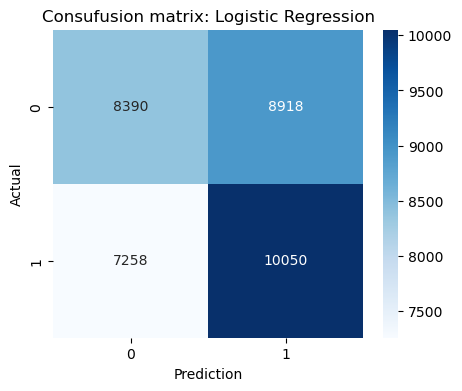


🔎 Model: Random Forest
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     17308
           1       0.92      1.00      0.96     17308

    accuracy                           0.96     34616
   macro avg       0.96      0.96      0.96     34616
weighted avg       0.96      0.96      0.96     34616



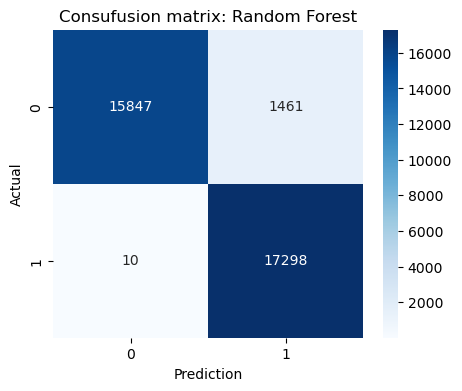


🔎 Model: Gradient Boosting
              precision    recall  f1-score   support

           0       0.63      0.63      0.63     17308
           1       0.63      0.62      0.63     17308

    accuracy                           0.63     34616
   macro avg       0.63      0.63      0.63     34616
weighted avg       0.63      0.63      0.63     34616



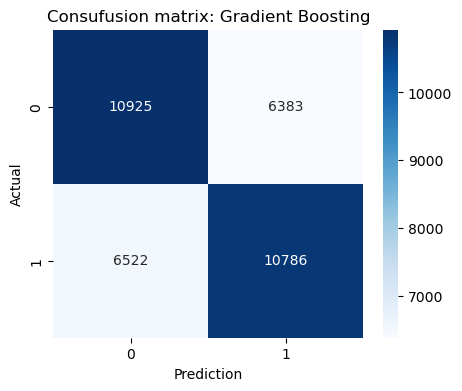


🔎 Model: K-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.86      0.85      0.86     17308
           1       0.85      0.86      0.86     17308

    accuracy                           0.86     34616
   macro avg       0.86      0.86      0.86     34616
weighted avg       0.86      0.86      0.86     34616



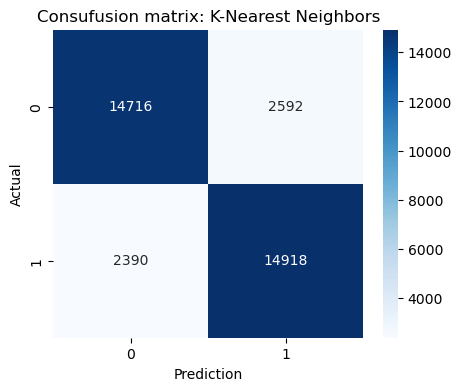

In [18]:
# Models list
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Train and show results
for nombre, modelo in modelos.items():
    print(f"\n🔎 Model: {nombre}")
    
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_train)

    # Reporte
    print(classification_report(y_train, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_train, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Consufusion matrix: {nombre}")
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    plt.show()

In [19]:
# Validation
X_validation, y_validation = aplicar_pipeline_con_filtro(validation_set, pipeline)

In [20]:
X_validation.shape

(35280, 12)

In [21]:
X_validation.head()

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Profession,CITY,STATE,Married.Single_single,House_Ownership_owned,House_Ownership_rented,Car_Ownership_yes
3725,-0.131513,-0.928445,11.0,6.0,10.0,8.0,307.0,25.0,1.0,0.0,1.0,0.0
59666,-0.664314,1.588970,15.0,14.0,10.0,37.0,179.0,23.0,1.0,0.0,1.0,1.0
88922,-0.209357,0.242445,2.0,2.0,10.0,22.0,192.0,25.0,1.0,0.0,1.0,0.0
77857,-1.585694,-1.455346,6.0,5.0,10.0,7.0,250.0,17.0,1.0,1.0,0.0,0.0
92236,-1.624247,0.769346,9.0,4.0,10.0,36.0,139.0,20.0,1.0,0.0,1.0,0.0



📊 Evaluating model: Logistic Regression
              precision    recall  f1-score   support

           0       0.90      0.49      0.63     30932
           1       0.14      0.60      0.23      4348

    accuracy                           0.50     35280
   macro avg       0.52      0.54      0.43     35280
weighted avg       0.80      0.50      0.58     35280



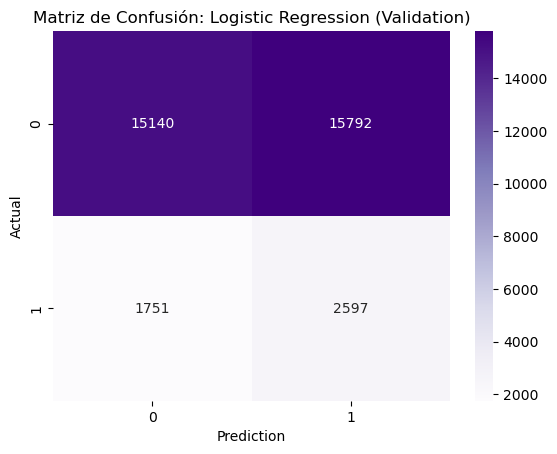


📊 Evaluating model: Random Forest
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     30932
           1       0.51      0.79      0.62      4348

    accuracy                           0.88     35280
   macro avg       0.74      0.84      0.77     35280
weighted avg       0.91      0.88      0.89     35280



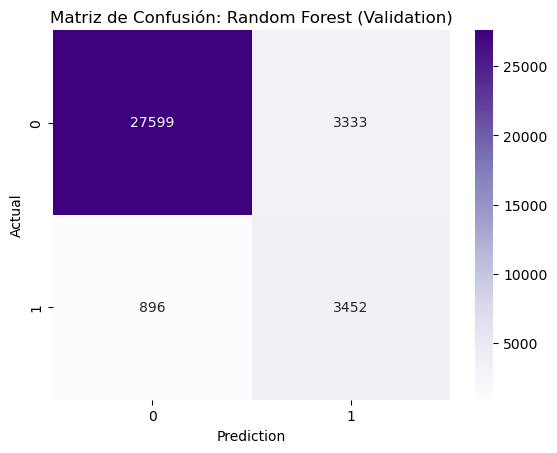


📊 Evaluating model: Gradient Boosting
              precision    recall  f1-score   support

           0       0.91      0.60      0.73     30932
           1       0.18      0.60      0.27      4348

    accuracy                           0.60     35280
   macro avg       0.55      0.60      0.50     35280
weighted avg       0.82      0.60      0.67     35280



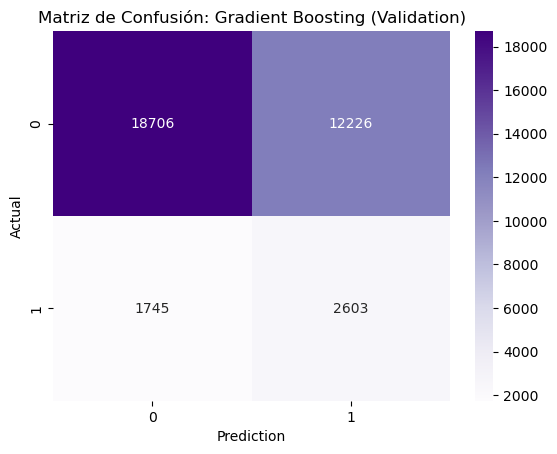


📊 Evaluating model: K-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.97      0.80      0.87     30932
           1       0.37      0.84      0.51      4348

    accuracy                           0.80     35280
   macro avg       0.67      0.82      0.69     35280
weighted avg       0.90      0.80      0.83     35280



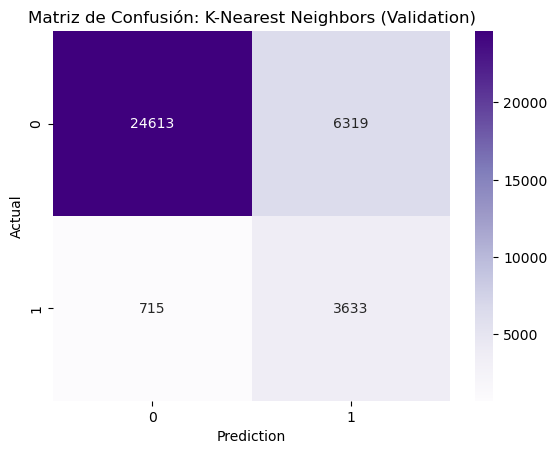

In [22]:
for nombre, modelo in modelos.items():
    print(f"\n📊 Evaluating model: {nombre}")
    y_val_pred = modelo.predict(X_validation)

    # Accuracy report
    print(classification_report(y_validation, y_val_pred))

    # Confusion matrix
    cm = confusion_matrix(y_validation, y_val_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
    plt.title(f"Matriz de Confusión: {nombre} (Validation)")
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    plt.show()

In [23]:
y_val_pred

array([0, 1, 1, ..., 1, 0, 0], dtype=int64)

### Accuracy model report

In [24]:
resultados = []

for nombre, modelo in modelos.items():
    # Accuracy in training
    y_train_pred = modelo.predict(X_train)
    acc_train = accuracy_score(y_train, y_train_pred)

    # Accuracy in validation
    y_val_pred = modelo.predict(X_validation)
    acc_val = accuracy_score(y_validation, y_val_pred)

    # Saving results
    resultados.append({
        'Modelo': nombre,
        'Accuracy Entrenamiento': round(acc_train, 4),
        'Accuracy Validación': round(acc_val, 4)
    })

# Showing results
resumen_accuracy = pd.DataFrame(resultados)
print(resumen_accuracy)

                Modelo  Accuracy Entrenamiento  Accuracy Validación
0  Logistic Regression                  0.5327               0.5027
1        Random Forest                  0.9575               0.8801
2    Gradient Boosting                  0.6272               0.6040
3  K-Nearest Neighbors                  0.8561               0.8006


## Using the trained models in the data set test

In [25]:
test = pd.read_csv('test.csv')
test.shape

(75600, 12)

In [26]:
test.head()

,Id,Income,Age,Experience,Married.Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
0,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12
1,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14
2,13,9120988,28,9,single,rented,no,Physician,Erode[17],Tamil_Nadu,9,12
3,14,8043880,57,12,single,rented,no,Financial_Analyst,Kollam,Kerala,8,10
4,15,9420838,48,6,single,rented,no,Technical_writer,Madurai,Tamil_Nadu,6,10


In [27]:
# Test
X_test, _ = aplicar_pipeline_con_filtro(test, pipeline)

In [28]:
X_test.shape

(75600, 12)

In [29]:
X_test.head()

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Profession,CITY,STATE,Married.Single_single,House_Ownership_owned,House_Ownership_rented,Car_Ownership_yes
0,0.439531,-0.525460,2.0,2.0,12.0,43.0,54.0,17.0,1.0,0.0,1.0,1.0
1,0.270362,-0.174414,11.0,3.0,14.0,11.0,296.0,22.0,1.0,0.0,1.0,0.0
2,1.433401,-1.286061,9.0,9.0,12.0,37.0,91.0,22.0,1.0,0.0,1.0,0.0
3,1.059691,0.410664,12.0,8.0,10.0,23.0,163.0,12.0,1.0,0.0,1.0,0.0
4,1.537436,-0.115906,6.0,6.0,10.0,47.0,178.0,22.0,1.0,0.0,1.0,0.0


In [30]:
# K-Nearest Neighbors
y_test_pred_k = modelos['K-Nearest Neighbors'].predict(X_test)

# Random Forest
y_test_pred_rf = modelos['Random Forest'].predict(X_test)

#Logistic regression
y_test_pred_lr = modelos['Logistic Regression'].predict(X_test)

#Gradient Boosting
y_test_pred_gb = modelos['Gradient Boosting'].predict(X_test)

In [31]:
def download_output(y_pred, name):
    output = pd.DataFrame({'Id': test.Id,
                           'Risk_Flag': y_pred})
    output.to_csv(name, index=False)

In [32]:
download_output(y_test_pred_k, 'K-Nearest_Neighbors_test.csv')
download_output(y_test_pred_rf, 'Random_Forest_test.csv')
download_output(y_test_pred_lr, 'Logistic_Regression_test.csv')
download_output(y_test_pred_gb, 'Gradient_Boosting_test.csv')

In [33]:
ver_resultado = pd.read_csv('Gradient_Boosting_test.csv')
print(ver_resultado.groupby('Risk_Flag').size() / len(test))
print(ver_resultado.shape)

Risk_Flag
0    0.581534
1    0.418466
dtype: float64
(75600, 2)


In [34]:
ver_resultado = pd.read_csv('Random_Forest_test.csv')
print(ver_resultado.groupby('Risk_Flag').size() / len(test))
print(ver_resultado.shape)

Risk_Flag
0    0.809974
1    0.190026
dtype: float64
(75600, 2)


### Fine tunning the model

#### Let's see the importance of the variables in the models

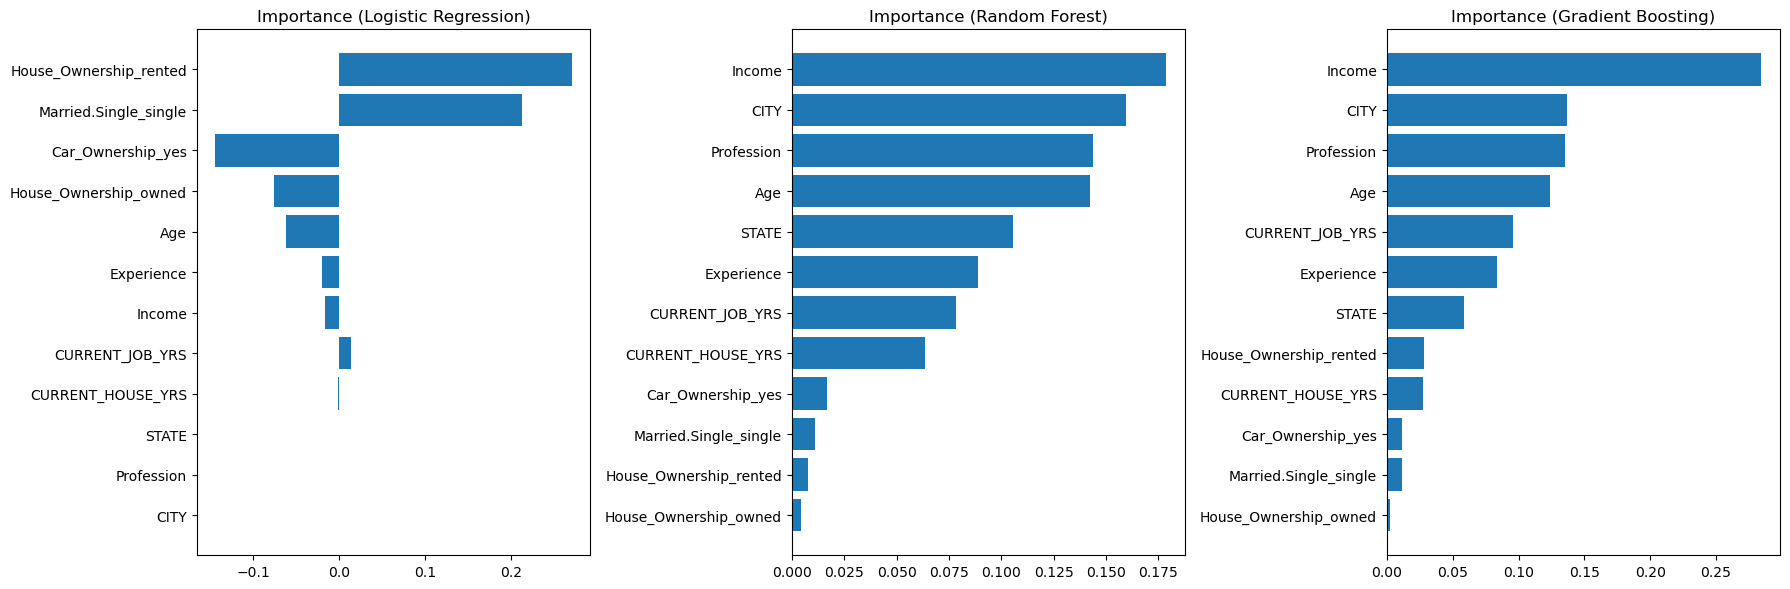

In [35]:
# Logistic Regression
importancia_log = pd.DataFrame({
    'Variable': X_train.columns,
    'Importance': modelos['Logistic Regression'].coef_[0]
}).sort_values(by='Importance', key=abs, ascending=False)

# Random Forest
importancia_rf = pd.DataFrame({
    'Variable': X_train.columns,
    'Importance': modelos['Random Forest'].feature_importances_
}).sort_values(by='Importance', ascending=False)

# Gradient Boosting
importancia_gb = pd.DataFrame({
    'Variable': X_train.columns,
    'Importance': modelos['Gradient Boosting'].feature_importances_
}).sort_values(by='Importance', ascending=False)

# 🔍 Charts to compare
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Logistic Regression
axes[0].barh(importancia_log['Variable'], importancia_log['Importance'])
axes[0].set_title('Importance (Logistic Regression)')
axes[0].invert_yaxis()

# Random Forest
axes[1].barh(importancia_rf['Variable'], importancia_rf['Importance'])
axes[1].set_title('Importance (Random Forest)')
axes[1].invert_yaxis()

# Gradient Boosting
axes[2].barh(importancia_gb['Variable'], importancia_gb['Importance'])
axes[2].set_title('Importance (Gradient Boosting)')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

In [36]:
X_train_pipeline = pipeline.fit_transform(train.drop(columns='Risk_Flag'))
nombres = pipeline.named_steps['preprocesador'].get_feature_names_out()

# Reconstruimos el DataFrame transformado
X_train_df = pd.DataFrame(X_train_pipeline, columns=nombres, index=train.index)

# Añadimos la columna objetivo
X_train_df['Risk_Flag'] = train['Risk_Flag']

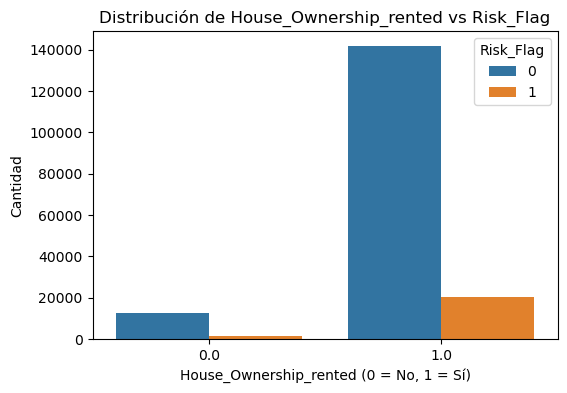

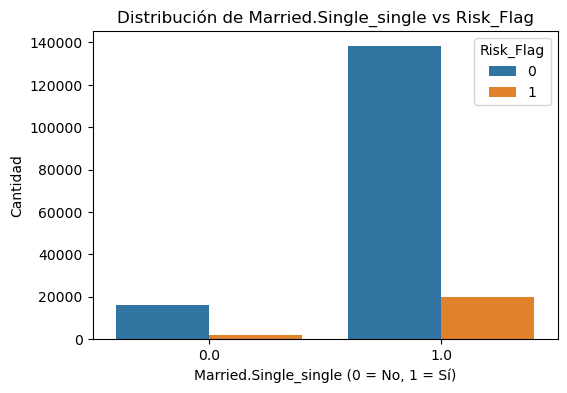

In [37]:
# House_Ownership_rented vs Risk_Flag
plt.figure(figsize=(6,4))
sns.countplot(data=X_train_df, x='House_Ownership_rented', hue='Risk_Flag')
plt.title('Distribución de House_Ownership_rented vs Risk_Flag')
plt.xlabel('House_Ownership_rented (0 = No, 1 = Sí)')
plt.ylabel('Cantidad')
plt.legend(title='Risk_Flag')
plt.show()

# Married.Single_single vs Risk_Flag
plt.figure(figsize=(6,4))
sns.countplot(data=X_train_df, x='Married.Single_single', hue='Risk_Flag')
plt.title('Distribución de Married.Single_single vs Risk_Flag')
plt.xlabel('Married.Single_single (0 = No, 1 = Sí)')
plt.ylabel('Cantidad')
plt.legend(title='Risk_Flag')
plt.show()

In [38]:
correlaciones_binarias = X_train_df[['Married.Single_single', 'House_Ownership_rented', 'Risk_Flag']].corr()
print(correlaciones_binarias['Risk_Flag'])

Married.Single_single     0.021837
House_Ownership_rented    0.026253
Risk_Flag                 1.000000
Name: Risk_Flag, dtype: float64


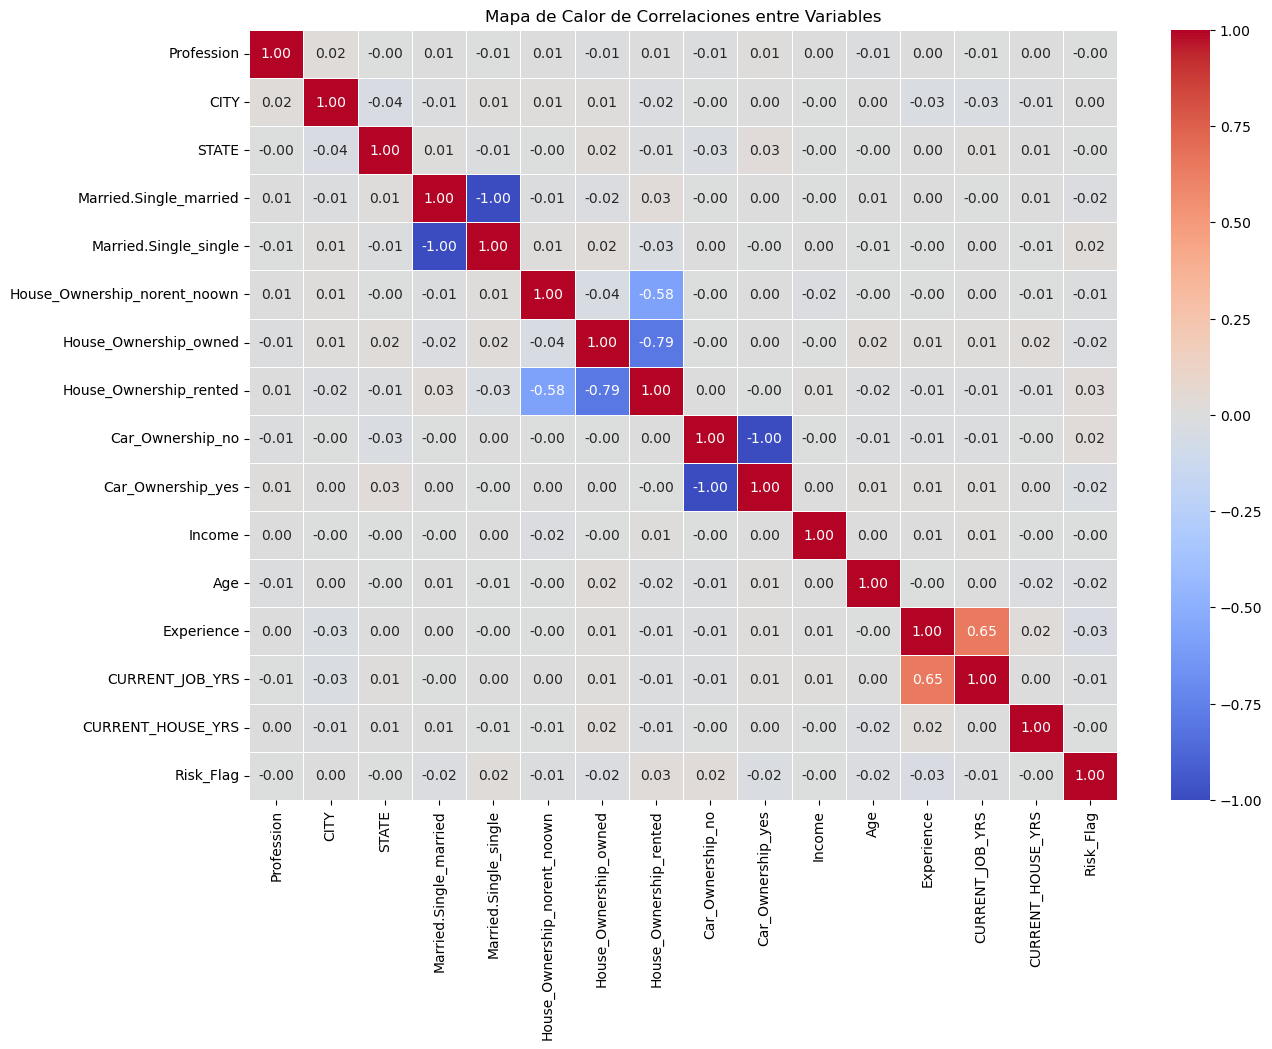

In [39]:
# Calculating correlations
matriz_corr = X_train_df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(matriz_corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title("Mapa de Calor de Correlaciones entre Variables")
plt.show()

### Esemble learning using Logistic Regression and Random Forest

I'm using these two models because they have different important variables

In [40]:
stacked_model = StackingClassifier(
    estimators=[
        ('log_reg', modelos['Logistic Regression']),
        ('random_forest', modelos['Random Forest'])
    ],
    final_estimator=LogisticRegression(),  # o cualquier otro
    passthrough=True
)

# Entrenamiento
stacked_model.fit(X_train, y_train)

# Evaluación
from sklearn.metrics import accuracy_score
y_val_pred = stacked_model.predict(X_validation)
print("Accuracy del modelo combinado:", accuracy_score(y_validation, y_val_pred))

C:\Users\hecto\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy del modelo combinado: 0.8700963718820862


It's accuracy is like the random forest accuracy by himself

In [41]:
# Predicciones sobre el conjunto de entrenamiento
y_train_pred_stack = stacked_model.predict(X_train)

# Cálculo del accuracy
acc_train_stack = accuracy_score(y_train, y_train_pred_stack)
print("📌 Accuracy en entrenamiento (StackingClassifier):", round(acc_train_stack, 4))

📌 Accuracy en entrenamiento (StackingClassifier): 0.9575


In [42]:
y_test_pred_stacked_model = stacked_model.predict(X_test)
download_output(y_test_pred_gb, 'Stacked_model_test.csv')

I did it but the Random forest works better alone

### ROC CURVE Analysis

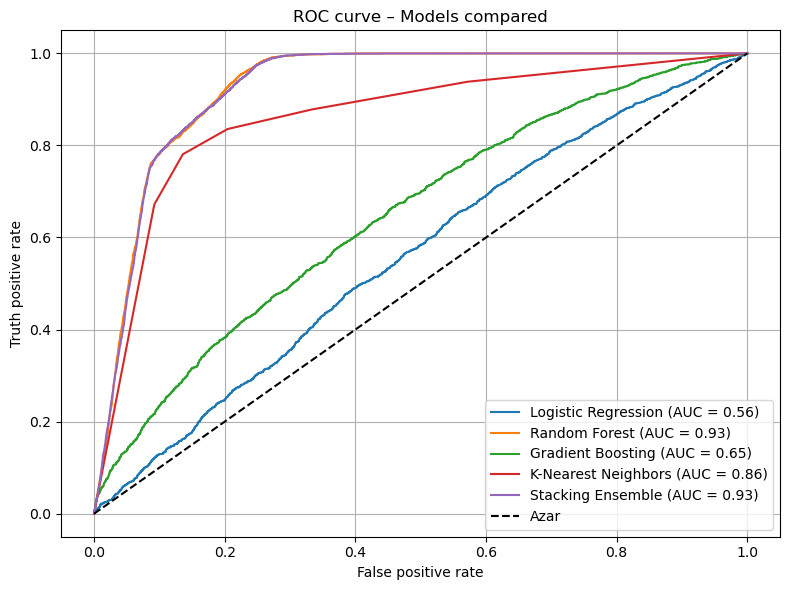

In [43]:
# Dictionary of models
modelos_roc = {
    'Logistic Regression': modelos['Logistic Regression'],
    'Random Forest': modelos['Random Forest'],
    'Gradient Boosting': modelos['Gradient Boosting'],
    'K-Nearest Neighbors': modelos['K-Nearest Neighbors'],
    'Stacking Ensemble': stacked_model
}

plt.figure(figsize=(8, 6))

for nombre, modelo in modelos_roc.items():
    # Obtaining positive class probabilities
    y_val_proba = modelo.predict_proba(X_validation)[:, 1]
    
    # Calculate ROC curve and area
    fpr, tpr, _ = roc_curve(y_validation, y_val_proba)
    auc = roc_auc_score(y_validation, y_val_proba)

    # Graphing
    plt.plot(fpr, tpr, label=f'{nombre} (AUC = {auc:.2f})')

# Diagonal line (random)
plt.plot([0, 1], [0, 1], 'k--', label='Azar')

plt.xlabel('False positive rate')
plt.ylabel('Truth positive rate')
plt.title('ROC curve – Models compared')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Final results in Kaggle - Random forest

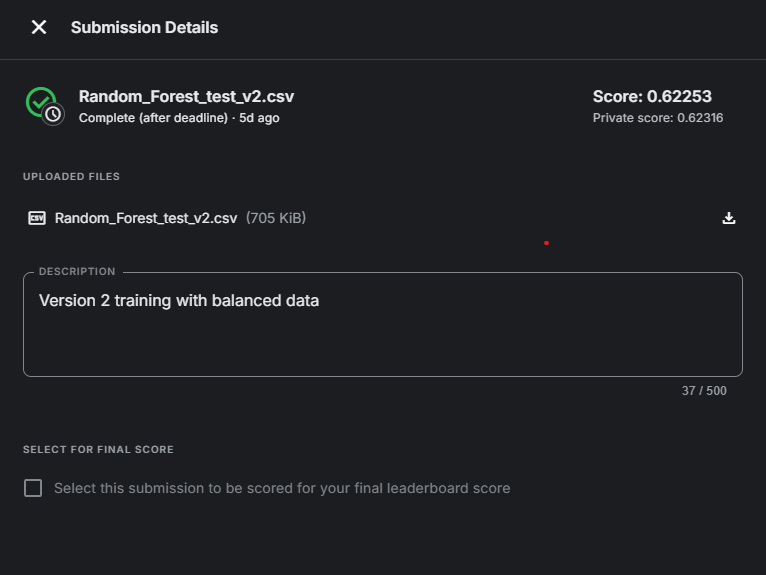

In [44]:
from IPython.display import Image, display

display(Image(filename='Kaggle_results_1.png'))

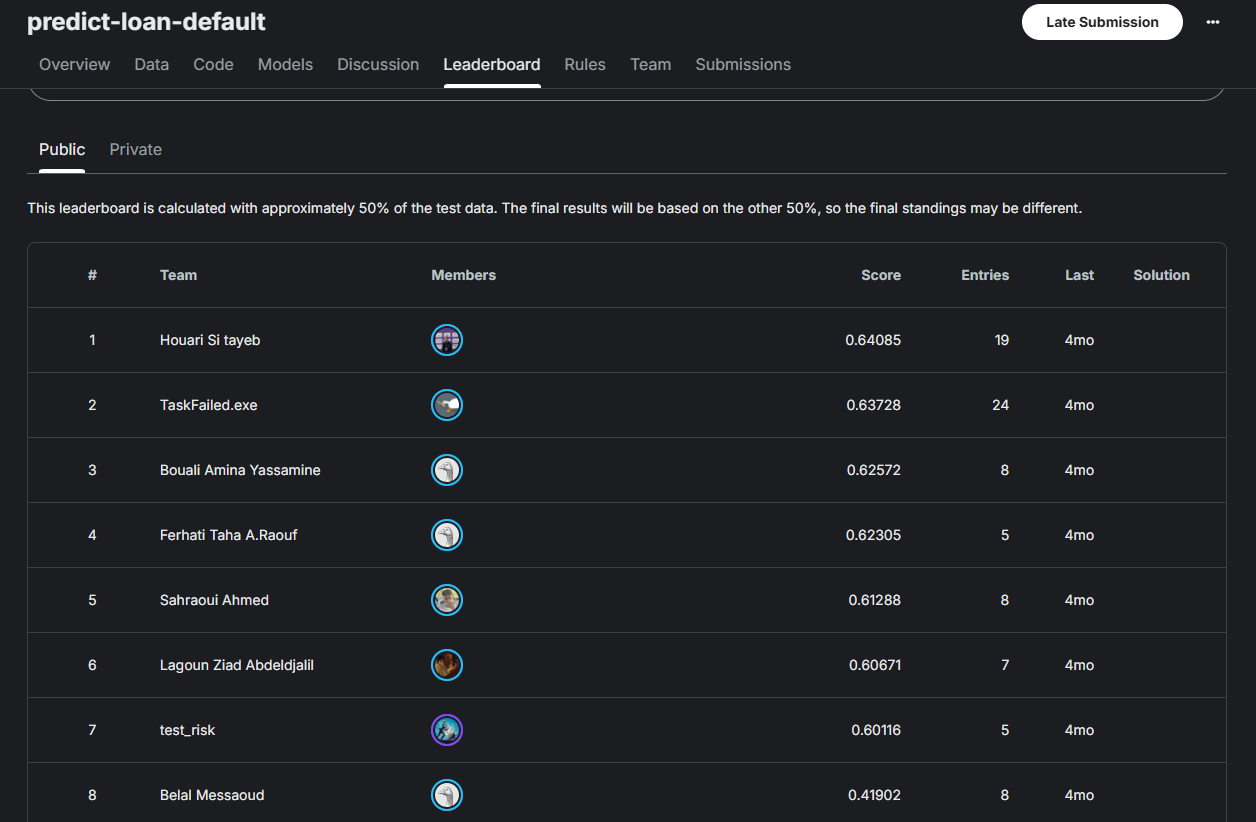

In [45]:
display(Image(filename='Kaggle_results_2.png'))

## The model would finish in fourth place, not bad for my first try